In [1]:
import numpy as np
import online_utils as utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import optimize

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

In [2]:
# Grid search parameters
ll_r = np.linspace(0.01, 0.99, 99)
alpha = 1e-5

# A first example

In [3]:
M = 2500000
p = 500

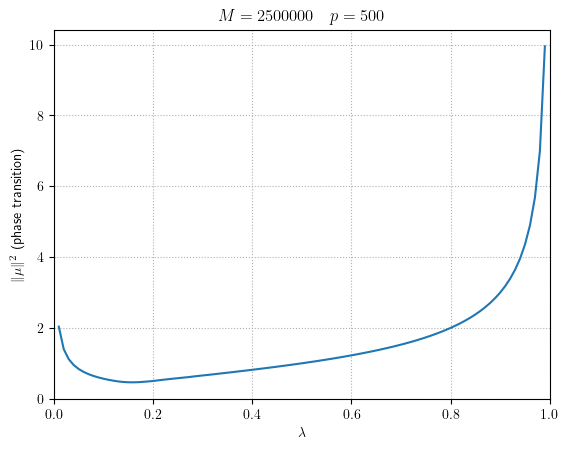

In [4]:
r = M/(p*p)
func = lambda ll: utils.phi(ll/(1-ll), 2*ll*ll*r/(1-ll))
grid = np.array([func(ll) for ll in ll_r])

plt.plot(ll_r, grid)
plt.grid(ls=':')
plt.xlim(0, 1)
plt.xlabel("$\\lambda$")
plt.ylabel("$\\| \\mu \\|^2$ (phase transition)")
plt.title("$M = {} \\quad p = {}$".format(M, p));

In [5]:
ll_argmin = ll_r[np.argmin(grid)]
a, b = max(alpha, ll_argmin-0.01), min(1-alpha, ll_argmin+0.01)
res = optimize.minimize_scalar(func, bracket=(a, b), method='brent')
print(res)
print("L = {}".format(res.x*M/p))
print("n = {}".format((1-res.x)*p/res.x))
print("c = {}".format(res.x/(1-res.x)))
print("eps = {}".format(2*res.x*res.x*r/(1-res.x)))

     fun: 0.46267424132605384
    nfev: 13
     nit: 9
 success: True
       x: 0.15735093178727844
L = 786.7546589363922
n = 2677.6106713873564
c = 0.18673364479121
eps = 0.5876542600786313


# Performance

In [6]:
memr = np.linspace(0.5, 100, 200)
opt_ll = np.empty_like(memr)*np.nan
pht = np.empty_like(memr)*np.nan

In [7]:
for i, r in enumerate(tqdm(memr)):
    func = lambda ll: utils.phi(ll/(1-ll), 2*ll*ll*r/(1-ll))
    grid = np.array([func(ll) for ll in ll_r])
    ll_argmin = ll_r[np.argmin(grid)]
    a, b = max(alpha, ll_argmin-0.01), min(1-alpha, ll_argmin+0.01)
    res = optimize.minimize_scalar(func, bracket=(a, b), method='brent')
    if res.success:
        opt_ll[i] = res.x
        pht[i] = res.fun
opt_eps = (2*(opt_ll**2)*memr)/(1-opt_ll)

100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


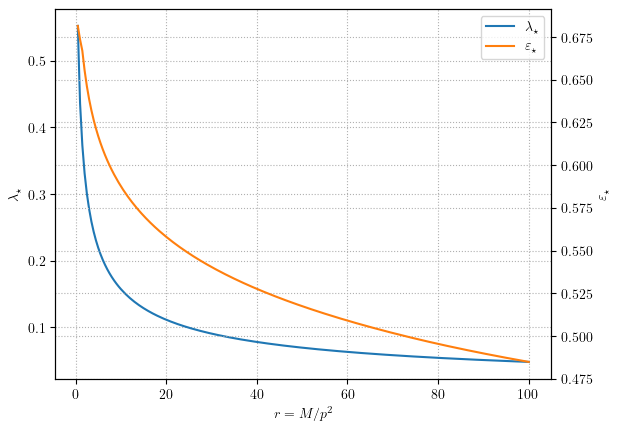

In [8]:
fig = plt.figure()
ax1 = plt.gca()
ax2 = ax1.twinx()

plot1 = ax1.plot(memr, opt_ll, color='C0', label="$\\lambda_\\star$", zorder=3)
ax1.grid(ls=':', zorder=2)
ax1.set_xlabel("$r = M / p^2$")
ax1.set_ylabel("$\\lambda_\\star$")

plot2 = ax2.plot(memr, opt_eps, color='C1', label="$\\varepsilon_\\star$", zorder=3)
ax2.grid(ls=':', zorder=2)
ax2.set_ylabel("$\\varepsilon_\\star$")

plots = plot1+plot2
labels = [plot.get_label() for plot in plots]
ax2.legend(plots, labels);

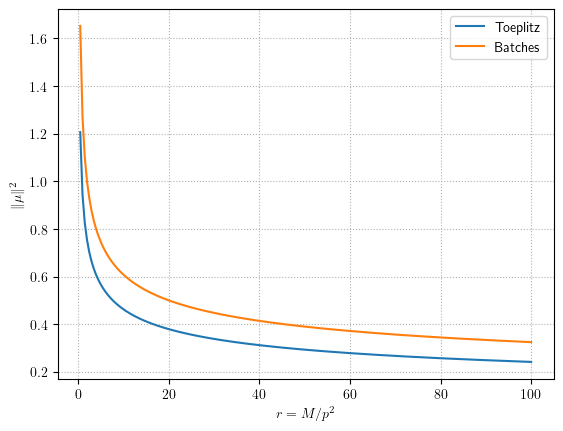

In [9]:
plt.plot(memr, pht, label="Toeplitz")
plt.plot(memr, np.sqrt(2/(-1+np.sqrt(1+4*memr))), label="Batches")
plt.grid(ls=':')
plt.xlabel("$r = M / p^2$")
plt.ylabel("$\\| \\mu \\|^2$")
plt.legend();